In [18]:
import warnings 
warnings.filterwarnings("ignore")

In [19]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from matplotlib import container

In [20]:
water_sub_df = pd.read_csv("aggregate_summary_all.csv", index_col=0)
main_df = pd.read_csv("../../aggregate_summary/aggregate_summary_waterSPCE.csv", index_col=0)

molecules = water_sub_df["molecule"]
molecule_set = set(molecules)
group_key = "molecule"


In [21]:
water_sub_df = water_sub_df[water_sub_df["engine"] == "gromacs"]
main_df = main_df[main_df["engine"] == "gromacs"]

In [22]:
water_sub_df

,molecule,engine,temperature,pressure,ensemble,forcefield_name,cutoff_style,long_range_correction,r_cut,pressure-avg,...,pressure-sem,temperature-avg,temperature-std,temperature-sem,potential_energy-avg,potential_energy-std,potential_energy-sem,density-avg,density-std,density-sem
0,waterSPCE,gromacs,300.0,101.325,NPT,spce_original,hard,energy_pressure,0.9,0.989559,...,1.116436,299.989484,0.100035,0.025009,-51381.012357,4.067552,1.016888,0.997891,0.000144,0.000036
1,waterSPCE,gromacs,300.0,101.325,NPT,spce_lammps,hard,energy_pressure,0.9,2.708825,...,2.032238,300.000714,0.092004,0.023001,-51343.765786,3.737096,0.934274,0.997422,0.000115,0.000029
2,waterSPCE,gromacs,320.0,101.325,NPT,spce_original,hard,energy_pressure,0.9,-0.292403,...,1.334351,319.968763,0.122952,0.030738,-50046.565704,3.937899,0.984475,0.986389,0.000120,0.000030
3,waterSPCE,gromacs,280.0,101.325,NPT,spce_original,hard,energy_pressure,0.9,0.261249,...,1.319255,280.017263,0.096068,0.024017,-52761.476130,3.511716,0.877929,1.006730,0.000156,0.000039
4,waterSPCE,gromacs,280.0,101.325,NPT,spce_lammps,hard,energy_pressure,0.9,0.952651,...,1.242688,279.958813,0.105136,0.026284,-52721.865929,4.497068,1.124267,1.006243,0.000106,0.000027
5,waterSPCE,gromacs,320.0,101.325,NPT,spce_lammps,hard,energy_pressure,0.9,-0.768363,...,1.596463,320.067795,0.110279,0.027570,-50006.834884,4.481387,1.120347,0.985857,0.000105,0.000026


In [23]:
main_df

,molecule,engine,temperature,pressure,ensemble,forcefield_name,cutoff_style,long_range_correction,r_cut,pressure-avg,...,pressure-sem,temperature-avg,temperature-std,temperature-sem,potential_energy-avg,potential_energy-std,potential_energy-sem,density-avg,density-std,density-sem
18,waterSPCE,gromacs,280.0,101.325,NPT,spce,hard,energy_pressure,0.9,0.906672,...,1.245417,279.981710,0.115924,0.028981,-52755.273195,3.138768,0.784692,1.006739,0.000158,0.000039
29,waterSPCE,gromacs,300.0,101.325,NPT,spce,hard,energy_pressure,0.9,2.078138,...,1.250810,300.033176,0.105315,0.026329,-51379.236139,5.093489,1.273372,0.997872,0.000106,0.000027
50,waterSPCE,gromacs,320.0,101.325,NPT,spce,hard,energy_pressure,0.9,2.306266,...,1.515300,320.021682,0.104812,0.026203,-50043.963561,4.371379,1.092845,0.986358,0.000102,0.000025


In [24]:
concat_df = pd.concat([water_sub_df, main_df])

In [25]:
plt.rcParams["font.family"] = "times" # "helvetica"
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


# Data cleaning and intial set up

In [26]:
def mean_confidence_interval(m,se, confidence=0.95):  
    se = np.array(se)
    n = 16
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [27]:
from pprint import pprint

def data_cleaning(molecule_set):
    """Make sure properties of all molecule in the provided molecule_set has been calculated."""
    for molecule in molecule_set:
        try:
            mol_group = concat_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            concat_df["temperature"].map(str)
            + "K, "
            + concat_df["pressure"].map(str)
            + "kPa, "
            + concat_df["forcefield_name"]
        )
        sp_set = set(mol_df["statepoint"])
        goods = list()
        bads = list()
        for engine in mol_df["engine"].unique():
            found_sp = mol_df[mol_df["engine"] == engine].index.tolist()
            if len(found_sp) == len(set(mol_df["statepoint"])):
                goods.append((engine, found_sp))
            else:
                mol_df.drop(axis=0, labels=found_sp, inplace=True)
                bads.append((engine, found_sp))

        if goods:
            print(f"\tPassed: {[good[0] for good in goods]}")
        if bads:
            print(f"\tFailed: {[bad[0] for bad in bads]}")
data_cleaning(molecule_set)

	Passed: ['gromacs']


# Style set up

In [28]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [29]:
molecules = ("waterSPCE",)
forcefield = ("spce_original", "spce-lammps") 
engines = ("lammps-VU", "gromacs",)


# Colors
symbols = {}
symbols["gromacs"] = "x" 
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["cassandra"] = "#009392" #(23/256, 109/256, 156/256)
colors["mcccs"] = "#39B1B5" #(194/256, 135/256, 32/256)
colors["gomc"] = "#9CCB86" #(21/256, 138/256, 106/256)
colors["gromacs"] = "#E9E29C" #(186/256, 97/256, 26/256)
colors["hoomd"] = "#EEB479" #(193/256, 130/256, 181/256)
colors["lammps-VU"] = "#E88471" #(188/256, 146/256, 110/256)

colors["spce_original"] = "#FF0000"
colors["spce_lammps"] = "#007FFF"
colors["spce"] = "#F0746E" # spce_gromacs
# colors_dict = {all_engine_molecule: all_engine_colors, 
#                pentane_fixed: pentane_fixed_colors,
#                pentane_flexible: pentane_flexible_colors}

pretty_names = {
    "gromacsspce": "SPC/E-GROMACS", 
    "gromacsspce_original": "SPC/E-Berendsen", 
    "gromacsspce_lammps": "SPC/E-LAMMPS",
}

fill_styles = {
    "gromacs": "full", 
    "lammps-VU": "full",
}

figsize = (9, 6)

In [30]:
import itertools

# Stack plots

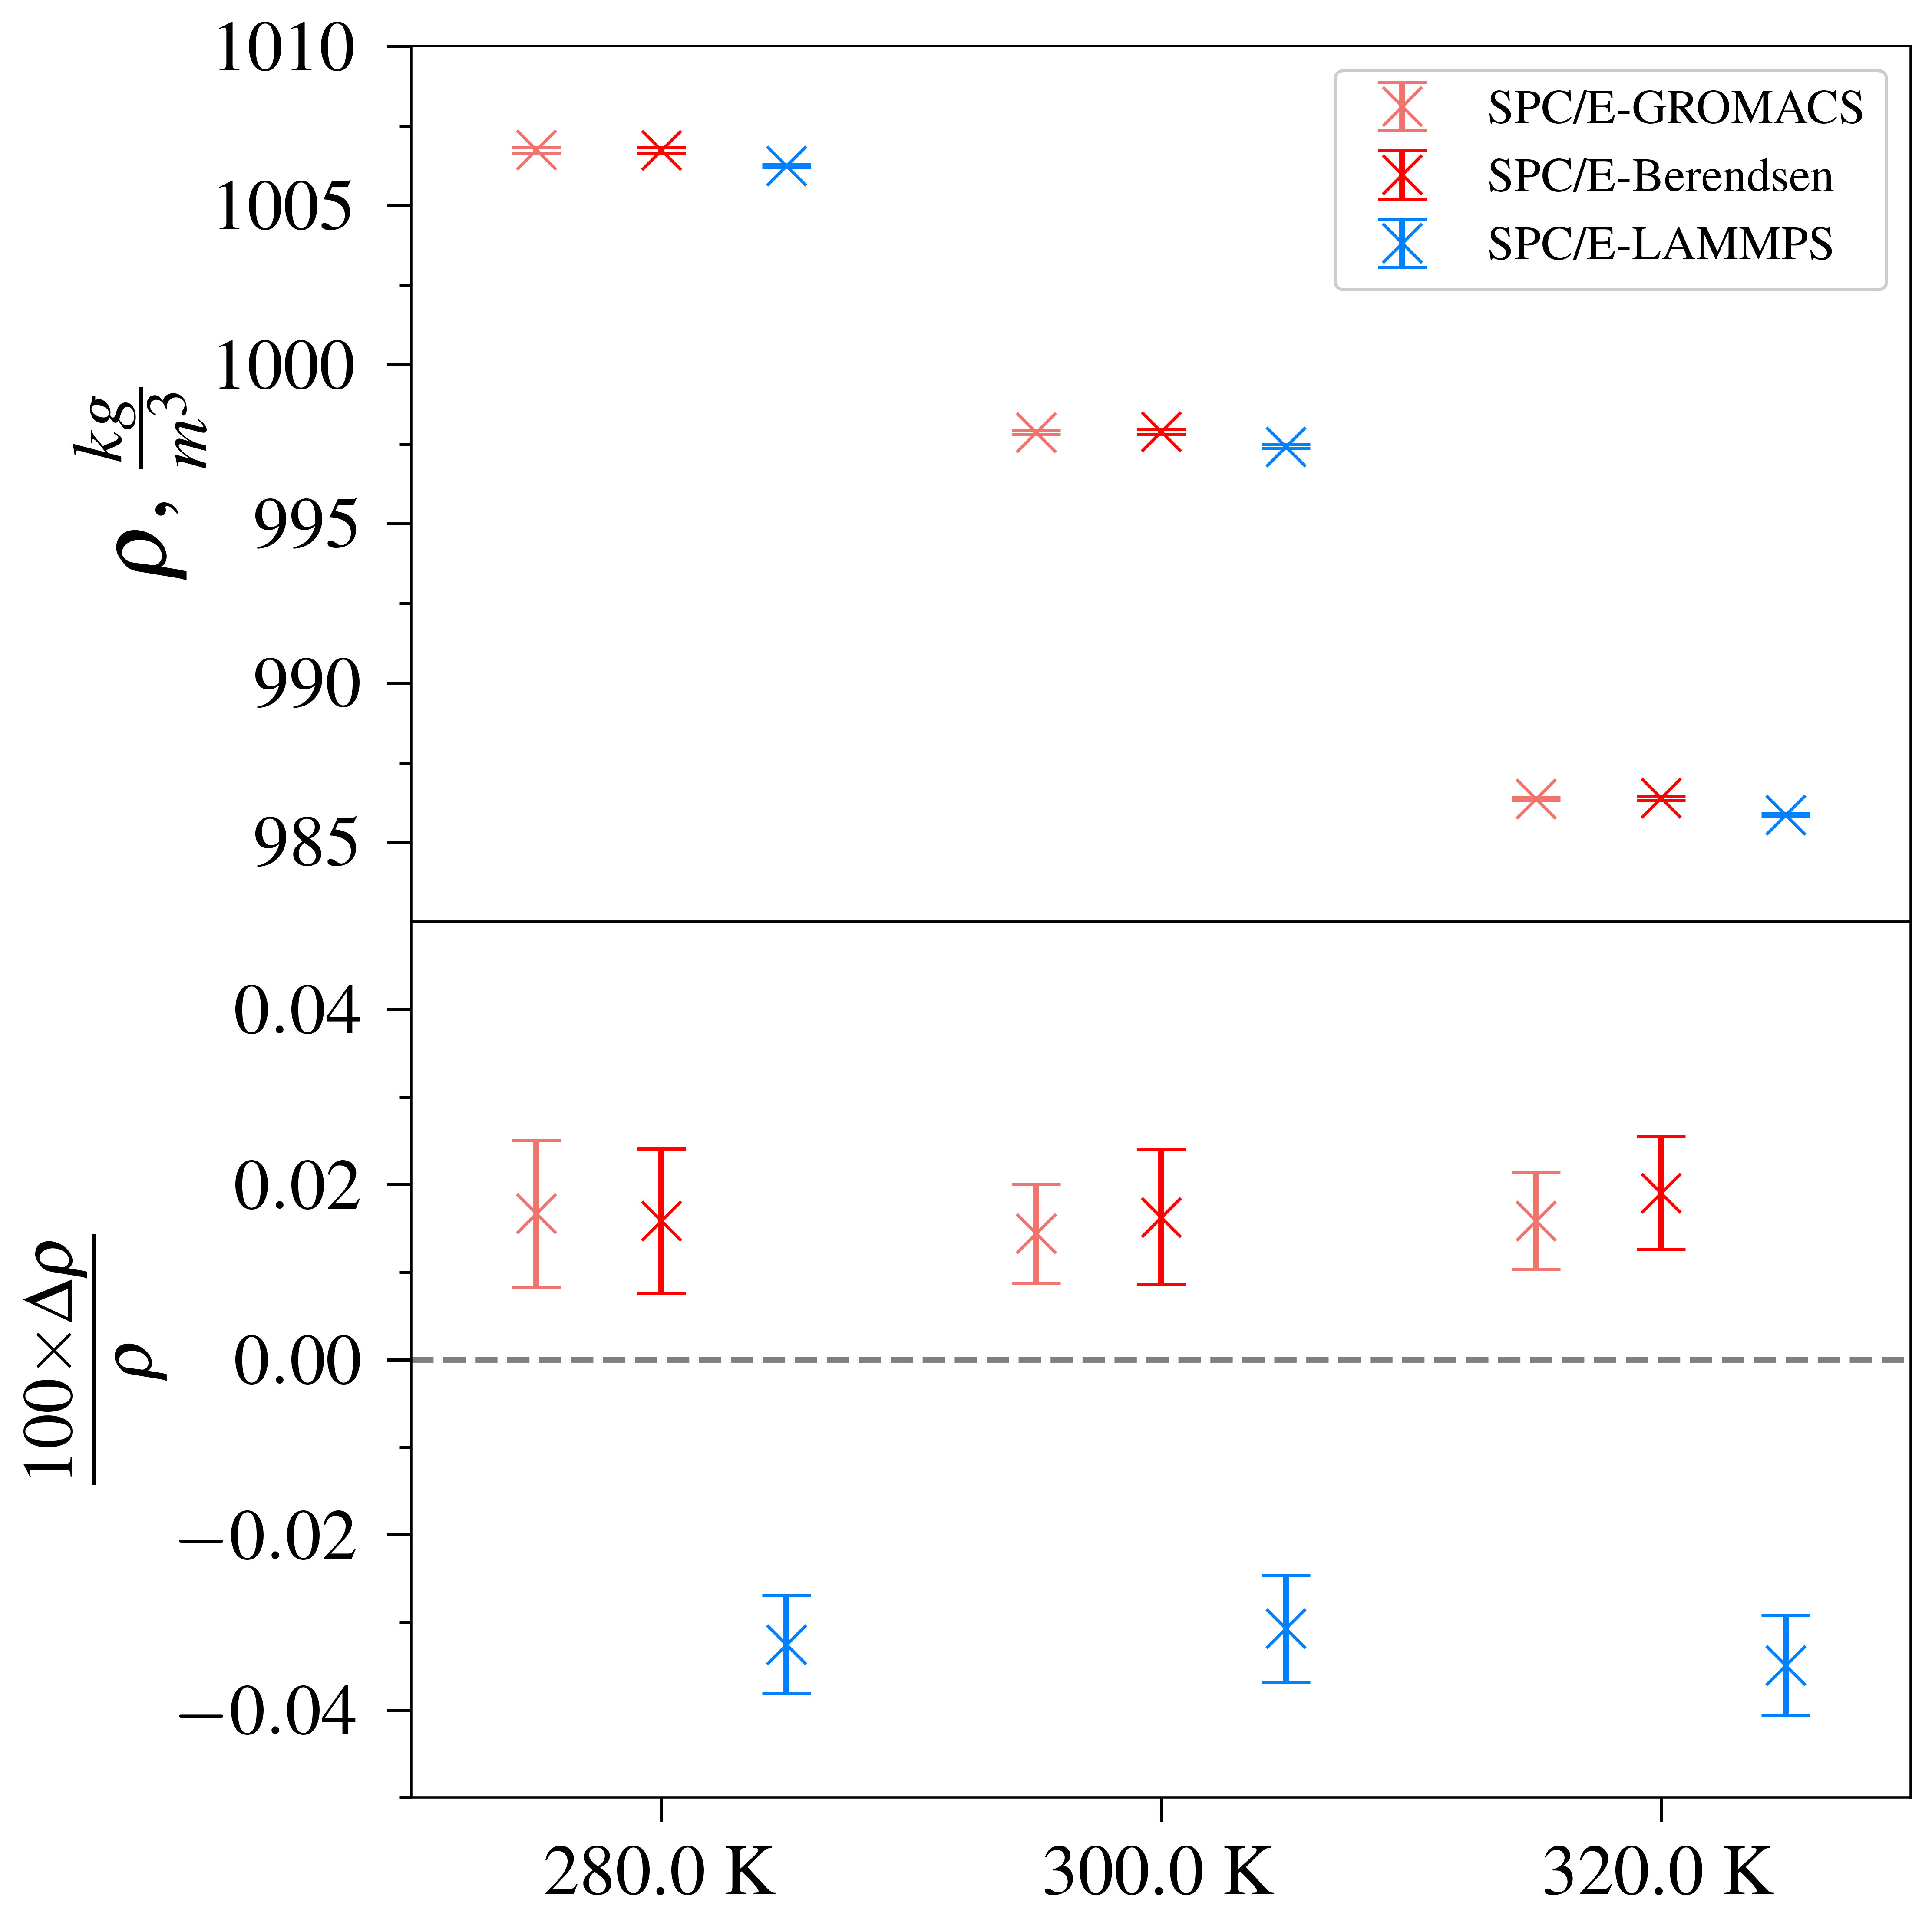

In [32]:
molecule = "waterSPCE"
engines = ["gromacs"]
ffs = {
    "280.0 K": ["spce", "spce_original", "spce_lammps"], 
    "300.0 K": ["spce", "spce_original", "spce_lammps"], 
    "320.0 K": ["spce", "spce_original", "spce_lammps"], 
}

figsize=(9, 9)
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(2, hspace=0)
ax = gs.subplots(sharex=True, sharey=False)

try:
    mol_group = concat_df.groupby(group_key)
    mol_df = mol_group.get_group(molecule)
except KeyError:
    print(f"skipping: {molecule}, no data available.")
    #continue

mol_df["statepoint"] = (
    concat_df["temperature"].map(str)
    + " K"
#    + concat_df["forcefield_name"]
    )

statepoints = sorted(set(mol_df["statepoint"]))
statepoints_overall_means = list()

xticks = list()
sps_positions = list()
for n_statepoint, statepoint in enumerate(statepoints):
    densities = list() 
    stds = list()
    sems = list()
    for engine in engines:
        for ff in ffs[statepoint]:
            shortlisted = mol_df[
                (mol_df["engine"] == engine) 
                & (mol_df["statepoint"] == statepoint)
                & (mol_df["forcefield_name"] == ff)]

            densities.append(shortlisted["density-avg"]*1000)
            stds.append(shortlisted["density-std"]*1000)
            sems.append(shortlisted["density-sem"]*1000)


                
    densities = [density for density in densities if density.values]
    overall_mean = np.mean(densities) 
    statepoints_overall_means.append(overall_mean) 
    
    confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
    percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
    percentage_sem_density = 100 * np.array(sems) / overall_mean
    percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean
    


    
    sp_position = list()
    counts = 0
    space_scaling = 2
    for i, engine in enumerate(engines):
        for j, ff in enumerate(ffs[statepoint]): 
            spacing = space_scaling *  n_statepoint + space_scaling/4*(i+j)
            sp_position.append(spacing)
            ax[0].errorbar(
                spacing, 
                densities[counts],
                marker=symbols[engine], 
                yerr=confidence_interval[counts], 
                color=colors[ff], 
                fillstyle=fill_styles[engine],
                ls='',
                label=engine+ff,
            )
            ax[1].errorbar(
                spacing, 
                percentage_delta_density[counts],
                marker=symbols[engine], 
                yerr=percentage_ci_density[counts], 
                color=colors[ff], 
                fillstyle=fill_styles[engine],
                ls='',
                label=engine+ff,
            )                
            counts +=1

            

    xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.3f}$'.format(overall_mean))
    sps_positions.append(np.mean(sp_position))


ax[1].axhline(y = 0, color = 'black', alpha=0.5, linestyle = '--')

#ax[1].set_xlabel("State point")
ax[1].set_ylabel(r"$\frac{100\times\Delta\rho}{\rho}$")
ax[0].set_ylabel(r"$\rho$,  $\frac{kg}{m^3}$")

ax[0].tick_params(axis='y')
#plt.title(f"{molecule}")
props = dict(boxstyle='round', facecolor='none',alpha=1, ec ='grey')
#string+='{:.5f}'.format(overall_mean)

ax[0].set_xticks([pos for pos in sps_positions])    
if len(statepoints) != 1:
    # ax[0].set_xticklabels([
    #     f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.3f}$'.format(sp_omean) 
    #     for sp_omean, sp in zip(statepoints_overall_means, statepoints)
    #     ]
    # )
    ax[0].set_xticklabels([statepoint for statepoint in statepoints])

    ax[0].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
    ax[1].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
else:
    plt.xticks([])


# Handle ylim 
low, high = ax[1].get_ylim()
bound = max(abs(low), abs(high))
#ax1.set_ylim(-bound*1.1, bound*1.1) 
ax[0].set_ylim(982.5, 1010)
ax[1].set_ylim(-0.05, 0.05)

# get handles
#wrap_labels(ax, 10)
handles, labels = ax[0].get_legend_handles_labels()

#Sorting handles and labels: 
labels_handles = dict()
for handle, label in zip(handles, labels):
    labels_handles[label] = handle

sorted_handles = [labels_handles[engine+ff] 
                  for engine, ff in itertools.product(engines, ffs["300.0 K"])]
sorted_labels = [pretty_names[engine+ff] 
                 for engine, ff in itertools.product(engines, ffs["300.0 K"])]

# plt.legend(sorted_handles, 
#            sorted_labels,
#            bbox_to_anchor=(1.05, 0.4),
#            bbox_transform=fig.transFigure,
#            labelspacing=2,
#            facecolor='white', 
#            loc='lower right',
#            prop={'size': 12},
#            ncol=1)


ax[0].legend(
           sorted_handles, 
           sorted_labels,
           #bbox_to_anchor=(0.6, 1.09),
           #bbox_transform=fig.transFigure,
           #labelspacing=2,
           facecolor='white', 
           loc="best", # 'upper center',
           prop={'size': 16},
           ncol=1
)
    
    
for i in range(2):
    ax[i].tick_params(which='both', width=1)
    ax[i].tick_params(which="major", length=8, axis="y", bottom=False)
    ax[i].tick_params(which="minor", length=4, axis="y", bottom=False)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

            
ax[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    ) # labels along the bottom edge are off
ax[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    length=8
    ) # labels along the bottom edge are off

        
plt.tight_layout()
ax[0].grid(alpha = 0., axis='x')
ax[1].grid(alpha = 0., axis='x')

import os
if not os.path.isdir("figures"):
    os.mkdir("figures")
plt.savefig(f'figures/water_stacked_deviation_density.pdf', dpi=500, bbox_inches="tight")

plt.show()
plt.close()

